# Classifying customer complaints with Watson NLP

Disclaimer: This notebook is intended to be used with an environment based on software configuration _Runtime 23.1 on Python 3.10_.

This notebook demonstrates how to train different text classifiers using Watson NLP. The classifiers predict the product group from the text of a customer complaint. This could be used, for example to route a complaint to the appropriate staff member. 

The data that is used in this notebook is taken from the Consumer Complaint Database that is published by the Consumer Financial Protection Bureau (CFPB), a U.S. government agency. The Consumer Complaint Database is a collection of complaints about consumer financial products and services that the CFPB sent to companies for response.  A complaint contains the consumer’s narrative description of their experience if the consumer opted to share this information publicly and after the Bureau has removed all personal information. In this notebook, you will focus on complaints that contain this narrative description to show how to use Watson NLP.

The data is publicly available at https://www.consumerfinance.gov/data-research/consumer-complaints/.

## What you'll learn in this notebook

Watson NLP implements state-of-the-art classification algorithms from three different families: 
- Classic machine learning using SVM (Support Vector Machines)
- Deep learning using CNN (Convolutional Neural Networks)
- Transformer-based models based on the pretrained Slate IBM Foundation model

Watson NLP also offers an easy to use _ensemble classifier_ which combines different classification algorithms and a majority voting.

In this notebook, you'll learn how to:

- **Prepare your data** so that it can be used as training data for the Watson NLP classification algorithms.
- **Train a custom SVM model** using `watson_nlp.blocks.classification.SVM`. SVM stands for Support Vector Machines. It's an established classification method. We will run it based on USE (Universal Sentence Encoder) embeddings of the input text.
- **Train a VotingEnsemble** using `watson_nlp.workflows.classification.GenericEnsemble`. Generic Ensemble allows to use any combination of the three base classifierts CNN, SVM with TF-IDF and SVM with USE (Universal Sentence Encoder). It computes the weighted mean of classification predictions using confidence scores.
- **Store and load classification models** as an asset of a Watson Studio project.
- **Score data and compare model quality** by running the models on test data and using the built-in quality evaluation and building a custom confusion matrix.


## Table of Contents


1. [Before you start](#beforeYouStart)
2. [Load the complaint data](#loadData)
3. [Prepare training and test data](#prepareData)
4. [Train a SVM classification model with Watson NLP](#svm)
5. [Train an ensemble classification model with Watson NLP](#ensemble)
6. [Store and load classification models](#storeLoad)
7. [Classify test data and compare model quality](#scoring)
8. [Summary](#summary)


<a id="beforeYouStart"></a>
## Before you start

Note that you can step through the notebook execution cell by cell, by selecting Shift-Enter. Or you can execute the entire notebook by selecting **Cell -> Run All** from the menu.



Begin by importing and initializing some helper libs that are used throughout the notebook.

In [1]:
import pandas as pd
# we want to show large text snippets to be able to explore the relevant text
pd.options.display.max_colwidth = 400

import json
import seaborn as sn
import matplotlib.pyplot as plt

In [2]:
import watson_nlp

from watson_core.data_model.streams.resolver import DataStreamResolver
from watson_core.toolkit import fileio
from watson_nlp.blocks.classification.svm import SVM

<a id="loadData"></a>
## Load the complaint data

The data can be downloaded via an API from https://www.consumerfinance.gov/data-research/consumer-complaints/. The data contains one month of data and only those complaints that contain the consumer narrative text. The data is exported in CSV format. The URL to retrieve this data looks like this:

In [3]:
url = "https://www.consumerfinance.gov/data-research/consumer-complaints/search/api/v1/?date_received_max=2021-03-30&date_received_min=2021-02-28&field=all&format=csv&has_narrative=true&no_aggs=true&size=18102"

Read the data into a dataframe.
You can find a detailed explanation of the available columns here: https://www.consumerfinance.gov/complaint/data-use/#:~:text=Types%20of%20complaint%20data%20we%20publish .

In your analysis you will focus on the *Product* column, which contains the product group, and the column with the complaint text *Consumer complaint narrative*.

In [4]:
complaint_df = pd.read_csv(url)
text_col = 'Consumer complaint narrative'

complaint_df.head(2)

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,03/23/21,"Credit reporting, credit repair services, or other personal consumer reports",Credit reporting,Incorrect information on your report,Information belongs to someone else,Unauthorized Inquiries On My Account. Cant Get In Contact With Anyone From Experian.,Company has responded to the consumer and the CFPB and chooses not to provide a public response,Experian Information Solutions Inc.,SC,29649,None,Consent provided,Web,03/23/21,Closed with explanation,Yes,NaN,4238810
1,03/30/21,"Credit reporting, credit repair services, or other personal consumer reports",Credit reporting,Incorrect information on your report,Account information incorrect,"I XXXX XXXX XXXX entered a consumer credit transaction with XXXX XXXX Bank on XX/XX/2017, due to this being a consumer credit transaction a finance charge was involved, 15 US code 1605 the amount of the finance charge in connection with any consumer credit transaction shall be determined as the sum of all charges. So there shouldn't be any late payments due this being a finance charge because ...",None,"EQUIFAX, INC.",CA,90620,None,Consent provided,Web,03/30/21,Closed with explanation,Yes,NaN,4258535


Let's look at all product groups that are available in the data set because these are the classes that the classifier should predict from a given complaint text.

In [5]:
product_counts = complaint_df['Product'].value_counts()
product_counts

Credit reporting, credit repair services, or other personal consumer reports    8890
Debt collection                                                                 3340
Credit card or prepaid card                                                     1555
Mortgage                                                                        1548
Checking or savings account                                                     1122
Money transfer, virtual currency, or money service                               914
Vehicle loan or lease                                                            373
Payday loan, title loan, or personal loan                                        193
Student loan                                                                     193
Name: Product, dtype: int64

<a id="prepareData"></a>
## Prepare training and test data

Many classification algorithms work best if the training samples are equally split across the classes. If the data is unbalanced, algorithms might decide to favor classes with many samples to achieve an overall good result. To avoid this, you will sample the data in the next step to have a similar amount of samples for each class.

To avoid long runtimes in this sample notebook, you will use only a small number of samples. However, this can reduce the quality of the classification models. In a real-case scenario, you should increase the number of samples per product group to get better results.

In [6]:
# number of complaints for the each product group
sample_size = 300

train_test_df = complaint_df.query("Product != 'Student loan' and Product != 'Payday loan, title loan, or personal loan'")

# sample the data to have the same number of complaints for each product group
train_test_df = train_test_df.groupby('Product').sample(n=sample_size, random_state=5).reset_index(drop=True)

In the next step, you will split the data into training and test data (ratio:80/20).

In [7]:
# 80% training data
train_orig_df = train_test_df.groupby('Product').sample(frac=0.8, random_state=6)
print("Training data:")
print("Number of training samples: {}".format(len(train_orig_df)))
print("Samples by product group:\n{}".format(train_orig_df['Product'].value_counts()))

# 20% test data
test_orig_df = train_test_df.drop(train_orig_df.index)
print("\nTest data:")
print("Number of test samples: {}".format(len(test_orig_df)))
print("Samples by product group:\n{}".format(test_orig_df['Product'].value_counts()))

# re-index after sampling
train_orig_df = train_orig_df.reset_index(drop=True)
test_orig_df = test_orig_df.reset_index(drop=True)

Training data:
Number of training samples: 1680
Samples by product group:
Checking or savings account                                                     240
Credit card or prepaid card                                                     240
Credit reporting, credit repair services, or other personal consumer reports    240
Debt collection                                                                 240
Money transfer, virtual currency, or money service                              240
Mortgage                                                                        240
Vehicle loan or lease                                                           240
Name: Product, dtype: int64

Test data:
Number of test samples: 420
Samples by product group:
Checking or savings account                                                     60
Credit card or prepaid card                                                     60
Credit reporting, credit repair services, or other personal consumer reports  

You have created two dataframes, one for the training and one for the test data. The data is still in its original format. Now you need to bring the data into a format that is usable by the Watson NLP classification algorithms. This can be either *JSON* or *CSV* format. 

In the sample, you will create the data in *JSON* format. The training and test data is written to files.

In [8]:
def prepare_data(df):
    # only the text column and the target label *Product* are needed
    df_out = df[[text_col, 'Product']].reset_index(drop=True)
    # rename to the identifiers expected by Watson NLP
    df_out = df_out.rename(columns={text_col: "text", 'Product': 'labels'})
    # the label column should be an array (although we have only one label per complaint)
    df_out['labels'] = df_out['labels'].map(lambda label: [label,])
    return df_out
    
train_df = prepare_data(train_orig_df)
train_file = './train_data.json'
train_df.to_json(train_file, orient='records')
    
test_df = prepare_data(test_orig_df)
test_file = './test_data.json'
test_df.to_json(test_file, orient='records')

train_df.head(2)

,text,labels
0,"I was working for my former employer I worked three pay periods and was paid once with a cold check, attempted to deposit the check that I assumed was good into my Capital One 360 account. The check bounced I have felony charges on them through the XXXX XXXX XXXX Sheriff 's Office for theft of services in the amount of {$4400.00} dollars. I have also submitted the forms and a copy of the poli...",[Checking or savings account]
1,"So recently my citizens bank mobile banking app was hacked into and a check was deposited for {$7800.00}, that was later returned because this was not me and the funds were insufficient. Then XXXX $ was transferred to someone named XXXX XXXX through the XXXX on my mobile banking. Then my XXXX XXXX was hacked because 4 separate transactions of XXXX $ were added to my XXXX XXXX and then sent o...",[Checking or savings account]


<a id="svm"></a>
## Train a SVM classification model with Watson NLP

SVM is an establishd classification approach. Watson NLP includes an SVM algorithm that exploits the `SnapML` libraries for faster training. The algorithm utilizes USE embeddings that encode word-level semantics into a vector space.

The SVM classifier block depends on the syntax block. So, start by loading the syntax model and the USE embeddings.

In [9]:
# Syntax Model
syntax_model = watson_nlp.load('syntax_izumo_en_stock')
# USE Embedding Model
use_model = watson_nlp.load('embedding_use_en_stock')

Classification blocks expect the training data in data streams. You can create data streams using several utility methods, as shown below.

In [10]:
training_data_file = train_file

# Create datastream from training data
data_stream_resolver = DataStreamResolver(target_stream_type=list, expected_keys={'text': str, 'labels': list})
training_data = data_stream_resolver.as_data_stream(training_data_file)

# Create Syntax stream
text_stream, labels_stream = training_data[0], training_data[1]
syntax_stream = syntax_model.stream(text_stream)

use_train_stream = use_model.stream(syntax_stream, doc_embed_style='raw_text')
use_svm_train_stream = watson_nlp.data_model.DataStream.zip(use_train_stream, labels_stream)

Train the classifier. **Note:** This cell will run for several minutes.

In [11]:
# Train the SVM model
svm_model = SVM.train(use_svm_train_stream)

Before you evalute the model, you will train another one and look at how to store and reload models from the project.

<a id="ensemble"></a>
## Train an ensemble classification model with Watson NLP

The ensemble model may combine three classification models: 

- SVM with TF-IDF features
- SVM with USE (Universal Sentence Encoder) features 
- CNN 

You will use SVM with TF-IDF and SVM with USE as algorithms for the Ensemble classifier.
It computes the weighted mean of classification predictions using confidence scores. You will use the default weights which can be fine-tuned in subsequent steps.

The ensemble workflow is very easy to use and the model performance can be a lot better than individual algorithms.

It depends on the syntax model and the USE embeddings. They are passed with the file containing the training data.

Train the ensemble classifier.

In [12]:
from watson_nlp.workflows.classification import GenericEnsemble
from watson_nlp.workflows.classification.base_classifier import TFidfSvm
from watson_nlp.workflows.classification.base_classifier import UseSvm

ensemble_model = GenericEnsemble.train(training_data, syntax_model, 
                                       base_classifiers_params=[
                                           TFidfSvm.TrainParams(syntax_model=syntax_model),
                                           UseSvm.TrainParams(syntax_model=syntax_model, use_embedding_model=use_model, doc_embed_style='raw_text')])

<a id="storeLoad"></a>
## Store and load classification models (optional)

You can save a model as a project asset. `model.as_bytes()` creates a ZIP archive, which is provided as a *BytesIO* object that is stored in the project.

**Note:** These steps are **optional**. You can skip them, and continue at [Classify test data and compare model quality](#scoring)

Save both models in your project.

In [13]:
from ibm_watson_studio_lib import access_project_or_space
wslib = access_project_or_space()

In [14]:
wslib.save_data('svm_model', data=svm_model.as_bytes(), overwrite=True)

{'name': 'svm_model',
 'asset_type': 'data_asset',
 'asset_id': '9c637932-45ed-48ca-a327-1528c4840466',
 'attachment_id': '1ea9dc8d-aebd-49cd-a818-b2e0981d219a',
 'filepath': 'svm_model.',
 'data_size': None,
 'mime': 'application/binary',
 'summary': ['created or overwritten file',
  'created data asset',
  'created attachment']}

In [15]:
wslib.save_data('ensemble_model', data=ensemble_model.as_bytes(), overwrite=True)

{'name': 'ensemble_model',
 'asset_type': 'data_asset',
 'asset_id': '914d1825-6b21-4f70-ab41-3b755e03e432',
 'attachment_id': 'ddcc66bd-b462-43c0-9d1b-de1e67968085',
 'filepath': 'ensemble_model.',
 'data_size': None,
 'mime': 'application/binary',
 'summary': ['created or overwritten file',
  'created data asset',
  'created attachment']}

The ZIP archive created by the `save_data` function is compatible to the `watson_nlp.load()` function that is also used to load the predefined Watson NLP models.

In [16]:
svm_model = watson_nlp.load(wslib.load_data('svm_model'))

In [17]:
ensemble_model = watson_nlp.load(wslib.load_data('ensemble_model'))

<a id="scoring"></a>
## Classify test data and compare model quality

Now you are able to run the trained models on new data. You will run the models on the test data so that the results can also be used for model evaluation. For illustration purposes, the data is used in the original format that you started out with because the format of the new complaints that you receive might also be in that format.

Notice that the SVM with USE embeddings model requires you to run the syntax model on the input texts first.

Create a helper method to run both models on a single complaint and return the predicted product groups of both models.

In [18]:
def predict_product(text):
    # run syntax model first
    syntax_result = syntax_model.run(text)
    # run SVM model on top of syntax result
    svm_preds = svm_model.run(use_model.run(syntax_result, doc_embed_style='raw_text'))
    
    predicted_svm = svm_preds.to_dict()["classes"][0]["class_name"]
    
    ensemble_preds = ensemble_model.run(text)
    predicted_ensemble = ensemble_preds.to_dict()["classes"][0]["class_name"]
    return (predicted_svm, predicted_ensemble)

Run the models on the complete test data.

In [19]:
predictions = test_orig_df[text_col].apply(lambda text: predict_product(text))
predictions_df = pd.DataFrame.from_records(predictions, columns=('Predicted SVM', 'Predicted Ensemble'))
   
result_df = test_orig_df[[text_col, "Product"]].merge(predictions_df, how='left', left_index=True, right_index=True)
result_df.head()

,Consumer complaint narrative,Product,Predicted SVM,Predicted Ensemble
0,"I opened a checking account in Bank of America around XX/XX/2021, using this account to receive services fee from my clients. I am self-employed account, providing tax and account service to our XXXX clients. The account balance is about {$3900.00} when the bank decided to close my account without any reasonable reason. I can't decide which account my clients use to pay me the money, but the b...",Checking or savings account,Credit card or prepaid card,Credit card or prepaid card
1,"I had my account closed by Chase without warning and since the federal policy requires banks to notify their clients of any warning related to a account closure, Chase unfortunately decided to act on bad faith and started the process without notifying me as required by law. I have tried everything, even as far as to visiting a branch and talking with the bank employees, who were overheard sayi...",Checking or savings account,Checking or savings account,Checking or savings account
2,"I am a victim of identity theft. The criminals established a "" KeyBank Hassle-Free Account '' at KeyBank in my name on or about XX/XX/2021. At the same time, they fraudulently applied for unemployment benefits in New York State and KeyBank, under the New York unemployment benefits program, also issued me a "" Key2Benefits '' mastercard debit card. I never applied to open either account with Key...",Checking or savings account,Checking or savings account,Checking or savings account
3,"I am not able to connect my external bank account to the savings account, i emailed credit karma support on XX/XX/XXXX and they replied back within minutes but they have not resolved my issue and now they wont reply back to any other emails I send. I have funds in this account and need access to it, Ive suggested they send me a check for my funds but Ive got no reply back, we are in the middle...",Checking or savings account,"Money transfer, virtual currency, or money service","Money transfer, virtual currency, or money service"
4,"I transferred money into my Bank of America current account on XX/XX/XXXX. My account cycle closes on XX/XX/XXXX. Bank of America held back those funds and cleared them on XX/XX/XXXX, a day after the close and charged me a {$12.00} maintenance fee. When I called to inquire, they said it was a clearing issue and refused to refund the money to me. I want my money back.",Checking or savings account,Checking or savings account,Checking or savings account


### Out-of-the-box model evaluation using Watson NLP

Watson NLP offers a method to calculate different quality metrics for a given model. Use the test data to evaluate the quality of your models.

In [20]:
# run the models on the test data - this time in batch mode
preprocess_func = lambda raw_doc: use_model.run_batch(syntax_model.run_batch(raw_doc))
svm_model.evaluate_quality(test_file, preprocess_func=preprocess_func)

{'per_class_confusion_matrix': {'Checking or savings account': {'true_positive': 22,
   'false_positive': 164,
   'false_negative': 38,
   'precision': 0.11827956989247312,
   'recall': 0.36666666666666664,
   'f1': 0.17886178861788618},
  'Debt collection': {'true_positive': 10,
   'false_positive': 62,
   'false_negative': 50,
   'precision': 0.1388888888888889,
   'recall': 0.16666666666666666,
   'f1': 0.1515151515151515},
  'Credit card or prepaid card': {'true_positive': 11,
   'false_positive': 48,
   'false_negative': 49,
   'precision': 0.1864406779661017,
   'recall': 0.18333333333333332,
   'f1': 0.18487394957983194},
  'Credit reporting, credit repair services, or other personal consumer reports': {'true_positive': 6,
   'false_positive': 37,
   'false_negative': 54,
   'precision': 0.13953488372093023,
   'recall': 0.1,
   'f1': 0.11650485436893203},
  'Mortgage': {'true_positive': 4,
   'false_positive': 11,
   'false_negative': 56,
   'precision': 0.26666666666666666,
  

You can see that the precision, recall and f1-measure for some classes is much lower than for others. The reason might be that it is difficult to differentiate between some classes. 

To find out if this is true, create a custom confusion matrix to see if there are classes that seem to be very close and might have been classified inappropriately.

### Creating and plotting a confusion matrix

Use the pandas *crosstab* to create a confusion matrix for both the SVM and the ensemble model and plot them as *Seaborn* heatmaps.

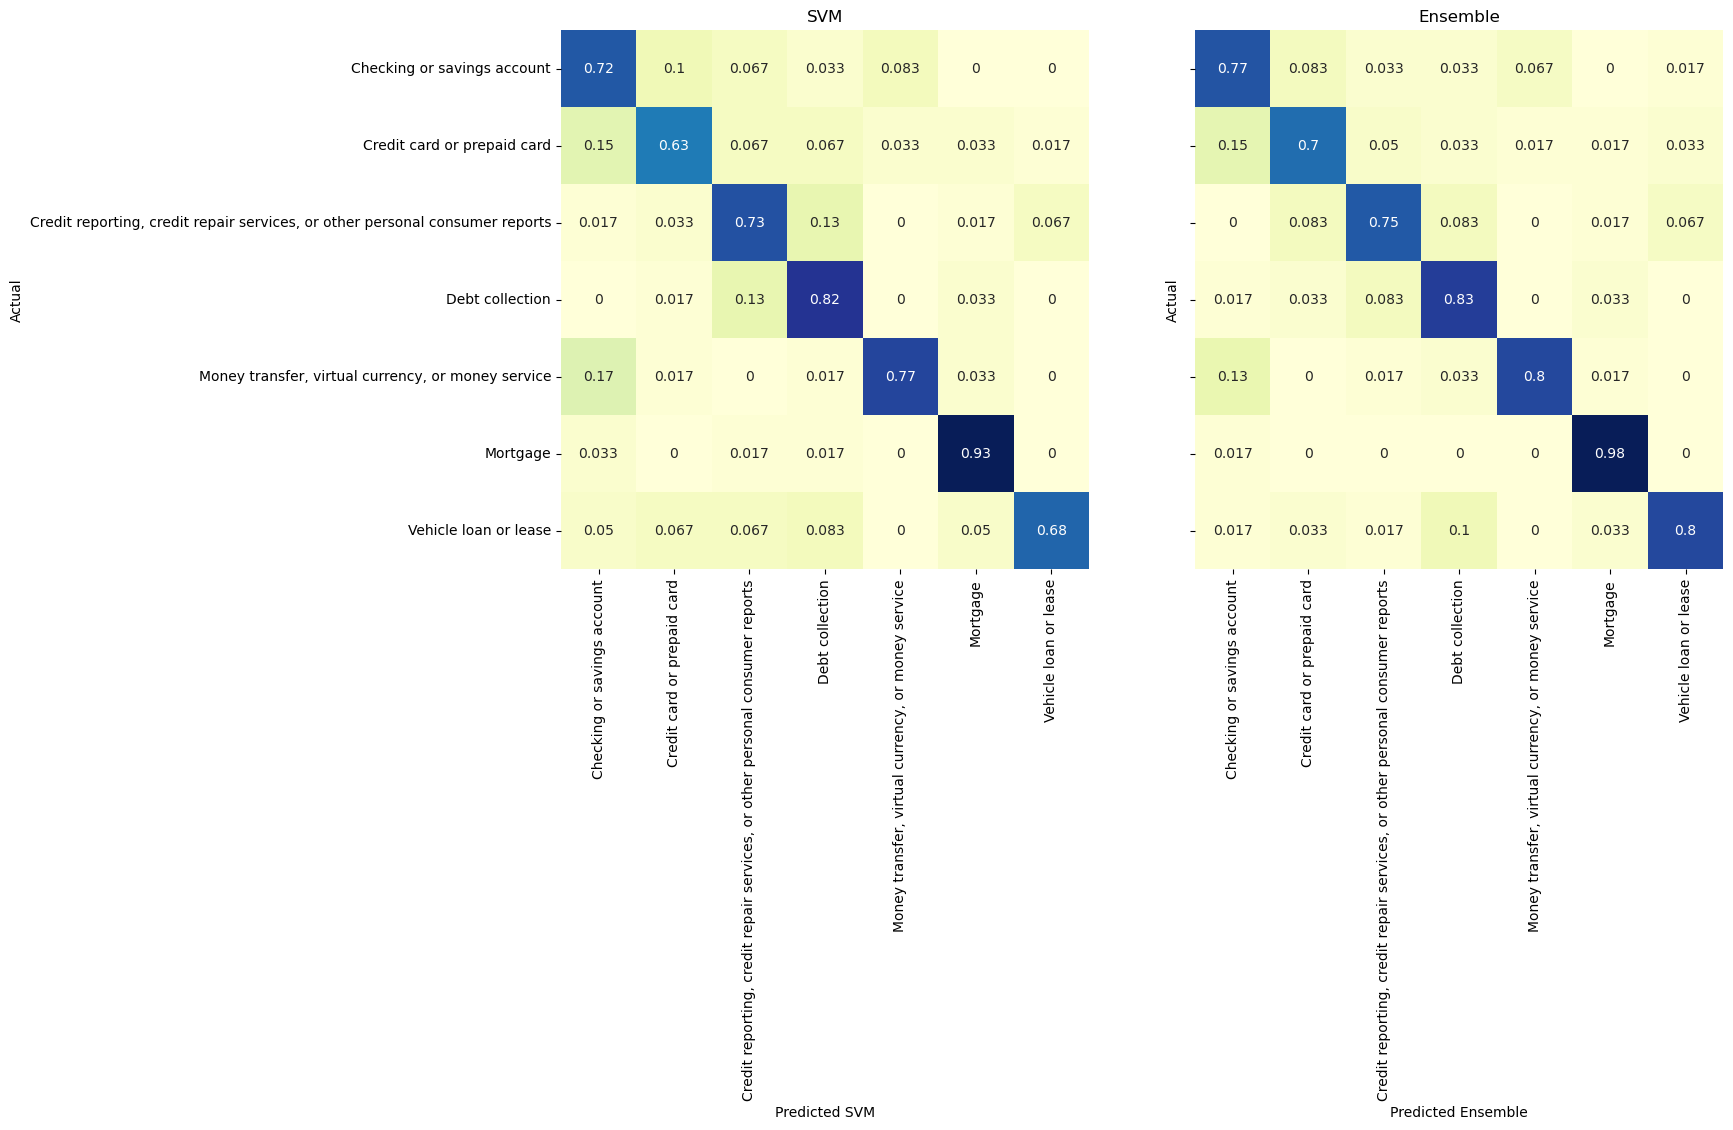

In [21]:
SVM_confusion_df = pd.crosstab(result_df['Product'], result_df['Predicted SVM'], rownames=['Actual'], normalize='index')
ensemble_confusion_df = pd.crosstab(result_df['Product'], result_df['Predicted Ensemble'], rownames=['Actual'], normalize='index')

figure, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,7))

sn.heatmap(SVM_confusion_df, annot=True, cmap="YlGnBu", ax=ax1, cbar=False)
sn.heatmap(ensemble_confusion_df, annot=True, cmap="YlGnBu", ax=ax2, cbar=False)
ax1.title.set_text("SVM")
ax2.title.set_text("Ensemble")
ax2.set_yticklabels([])

plt.show()

#### Findings

In the confusion matrix for the SVM model you can now see that complaints for `Credit reporting, credit repair services, or other personal consumer reports` are often misclassified as `Debt collection` - and vice versa. Other common misclassifications can be gathered from the table.

Overall, the ensemble model performs better than the SVM model. 

In subsequent steps, consider increasing the size of the training data or adjusting the weights of the ensemble model to gain better results.

<a id="summary"></a>
## Summary

This notebook shows you how to use the Watson NLP library and how quickly and easily you can train and run different text classifiers using Watson NLP.

### Authors
Simone Zerfass IBM, Germany

Alexander Lang IBM, Germany

# <hr>
Copyright © 2021 IBM. This notebook and its source code are released under the terms of the MIT License.